In [20]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

from balancers import PredictionBalancer
import tools

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity

from utils import *
from demv import DEMV
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

Protected groups : age = 0, sex = 0 

Positive label : credit = 1

In [21]:
data = pd.read_csv('data2/german.csv', index_col=0)

In [22]:
data.loc[:,"combined"] = 0
data.loc[(data['sex'] == 0) & (data["age"] == 0),"combined"] = 1

In [23]:
data

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit,combined
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0


In [24]:
label = 'credit'
positive_label = 1
sensitive_features = ['combined']
unpriv_group = {'combined': 0}

In [25]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased data

In [26]:
model, bias_metrics, y_pred = cross_val2(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [27]:
print_metrics(bias_metrics)

Statistical parity:  0.215  +-  0.146
Disparate impact:  0.725  +-  0.173
Zero one loss:  0.137  +-  0.077
F1 score:  0.734  +-  0.044
Accuracy score:  0.743  +-  0.043


## DEMV

In [28]:
demv_data = data.copy()
demv = DEMV(round_level=1)

In [29]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [30]:
print_metrics(demv_metrics)

Statistical parity:  0.122  +-  0.151
Disparate impact:  0.813  +-  0.156
Zero one loss:  0.129  +-  0.101
F1 score:  0.731  +-  0.038
Accuracy score:  0.743  +-  0.035


## Post-Processing adjustment

Since the label is binary, no further change is needed.

In [31]:
a = data.combined.values

In [32]:
y_ = []
for list in y_pred:
    for j in list:
        y_.append(int(j))

y_ = np.array(y_)

y_ = np.array(y_ == 1.0 , dtype=np.uint8)

In [33]:
y = np.array(data.credit == 1.0, dtype=np.uint8)
y = np.array(y)

In [34]:
pb = PredictionBalancer(y=y, y_=y_, a=a)


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.7075 0.7819
   1.0 0.8298 0.7759

And loss is 0.3710



In [35]:
y_adj = pb.adjust(summary = True)


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  1.0  1.0
   1.0  1.0  1.0

And loss is 0.3000



In [36]:
datapred = deepcopy(data)
datapred[label] = y_adj

blackboxmetrics = get_metrics( data, datapred , unpriv_group, label, positive_label   )

## DEMV Evaluation

In [37]:
metrics = eval_demv(2, demv.get_iters(), data.copy(), pipeline, label, unpriv_group, sensitive_features, positive_label=positive_label)

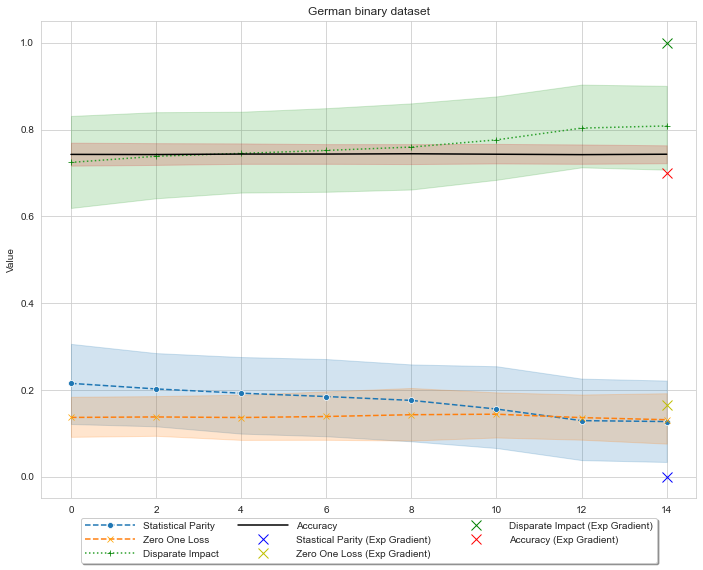

Dataset size: 1000
Unprivileged group size: 895
Percentage of unprivileged group: 89.5
Number of iterations: 14


In [38]:
df = prepareplots(metrics,'german')
points = preparepoints(blackboxmetrics,demv.get_iters())

plot_metrics_curves(df, points, 'German binary dataset')
unprivpergentage(data,unpriv_group, demv.get_iters())